# The Effect of $\delta_C$ and $s_C$ on Competition between WT and KOs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import sbi.utils as utils
import torch
from sbi.inference import MCMCPosterior
from scipy.special import logsumexp

from collective_posterior import CollectivePosterior

import matplotlib as mpl
plt.rcParams['figure.dpi'] = 600

## Getting Collective Posterior Samples

In [2]:
# Prior doesn't have to be identical to network's prior (here it is)
prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
prior_max = np.log10(np.array([1,1e-2,1e-2]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))
posterior_chuong = pickle.load(open(f'posteriors/posterior_chuong.pkl', 'rb'))
# posterior_lauer = pickle.load(open(f'posteriors/posterior_lauer.pkl', 'rb'))
n_eval = 300 # N used to calculate normalizng constant
epsilon = -150 # choice is detailed later
log_Cs = pd.read_csv('posteriors/log_Cs.csv', index_col=0) # pre-saved normalizing constant
sample_df = pd.read_csv('maps/collective_posterior_samples.csv', index_col=0) # pre-saved samples

collective_posteriors = {}

lines = ['wt', 'ltr', 'ars', 'all']
for line in lines:
    amortized_posterior = posterior_lauer if line=='lauer' else posterior_chuong
    Xs = pd.read_csv(f'empirical_data/{line}.csv', index_col=0) # observations
    log_C = float(log_Cs.loc[line,str(epsilon)]) # normalizing constant
    op = CollectivePosterior(prior, amortized_posterior, Xs, n_eval, log_C, epsilon)
    samples = sample_df[sample_df['line']==line].iloc[:,1:] # only parameter values
    op.samples = torch.tensor(np.array(samples,dtype='float64')).reshape(len(samples),3)
    collective_posteriors[line] = op # to use throughout the notebook
    
rep_colors = {'wt':"black", 'ltr':"#6699cc", 'ars': "#e26d5c", 'all':"#DEBD52", "lauer": "grey"}
label_dict = {'wt': 'Wild type architecture', 'ltr': 'LTRs removed', 'ars': 'ARS removed', 'all': 'LTR and ARS removed', 'lauer': 'Lauer'}

## Competition Simulations

In [6]:
from simulate_competition import CNVsimulator_simpleWF as competition


reps = 1
generation = pd.read_csv('Chuong_116_gens.txt', delimiter = ', ', engine='python')
generation = generation.columns.astype('int')
N = 3.3e8


def CompSimulator(parameters):
    cnv_params = np.asarray(torch.squeeze(parameters,0))
    states = competition(reps = reps, N=N, generation=generation, seed=73, parameters=cnv_params)
    return states[0][:,-1]

def competition_estimation(g1, g2, samples=100):
    k = []
    for i in range(samples):
        for j in range(samples):
            s_1, m_1 = collective_posteriors[g1].samples[i,0:-1]
            s_2, m_2 = collective_posteriors[g2].samples[j,0:-1]
            states = CompSimulator(torch.tensor([s_1,s_2,m_1,m_2]))
            k.append(states[0])
    k = np.array(k)
    print(k.mean())
    return k

0.7169734892778789


/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


0.998394867459394


/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


0.9990035026781817


/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


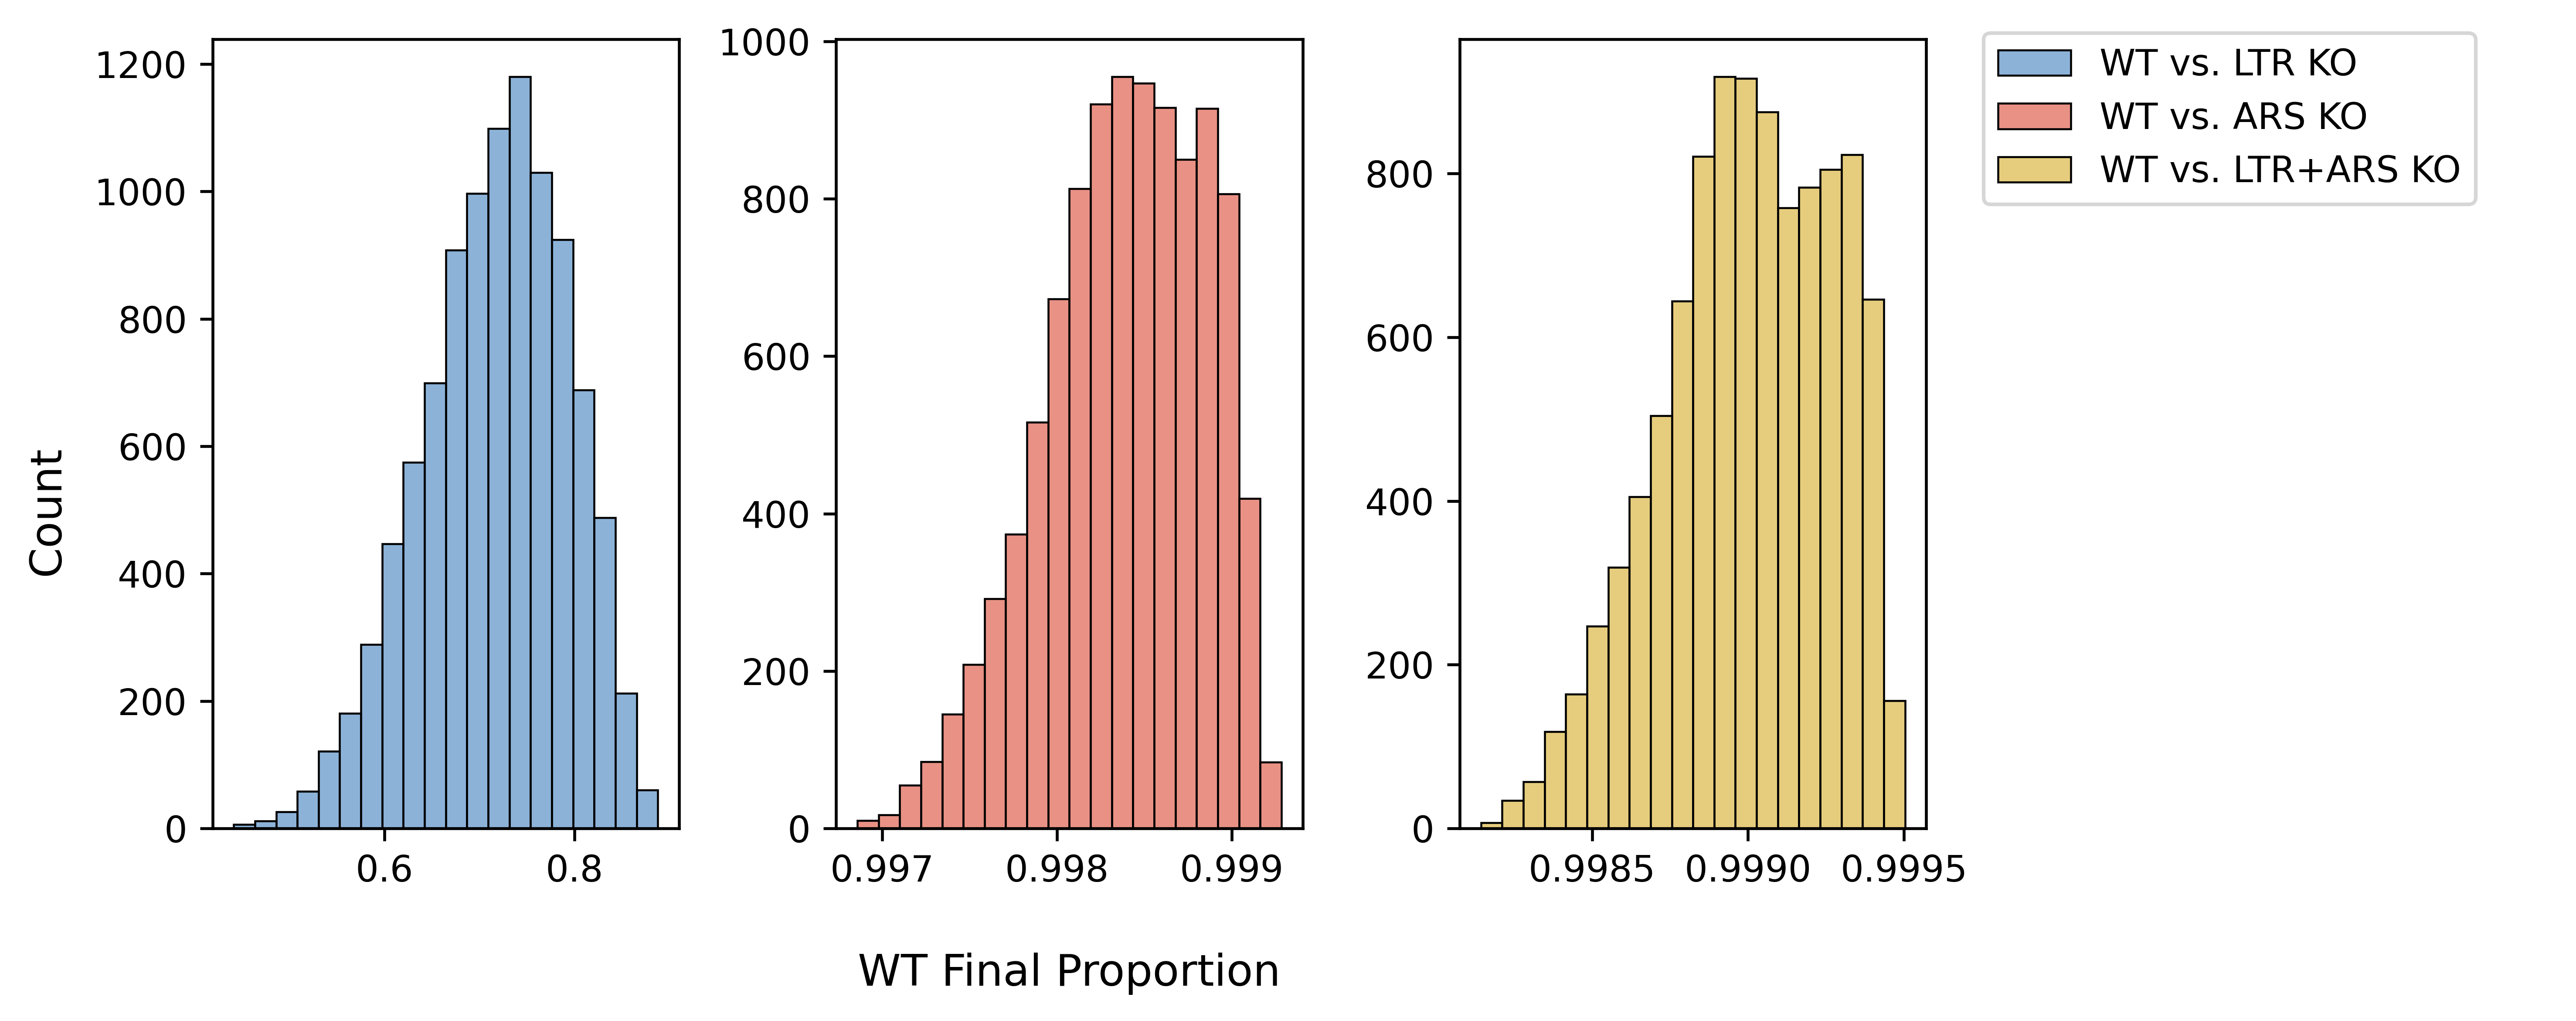

In [7]:
from seaborn import histplot as hst
fig, ax = plt.subplots(1,4, tight_layout=True, figsize=(10,4))

vs_ltr_final_prop = competition_estimation('wt', 'ltr')
hst(vs_ltr_final_prop, color=rep_colors['ltr'], label='WT vs. LTR KO', bins=20, ax=ax[0])

vs_ars_final_prop = competition_estimation('wt', 'ars')
hst(vs_ars_final_prop, color=rep_colors['ars'], label='WT vs. ARS KO', bins=20, ax=ax[1])

vs_all_final_prop = competition_estimation('wt', 'all')
hst(vs_all_final_prop, color=rep_colors['all'], label='WT vs. LTR+ARS KO', bins=20, ax=ax[2])

ax[3].set_axis_off() # room for legend

ax[1].set_xlabel('\nWT Final Proportion', fontsize=12)
fig.supylabel('Count')
fig.legend(fontsize=10, loc = (0.77,0.8))
for j in range(3):    
        ax[j].set_ylabel('')

0.6217987968287878


/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


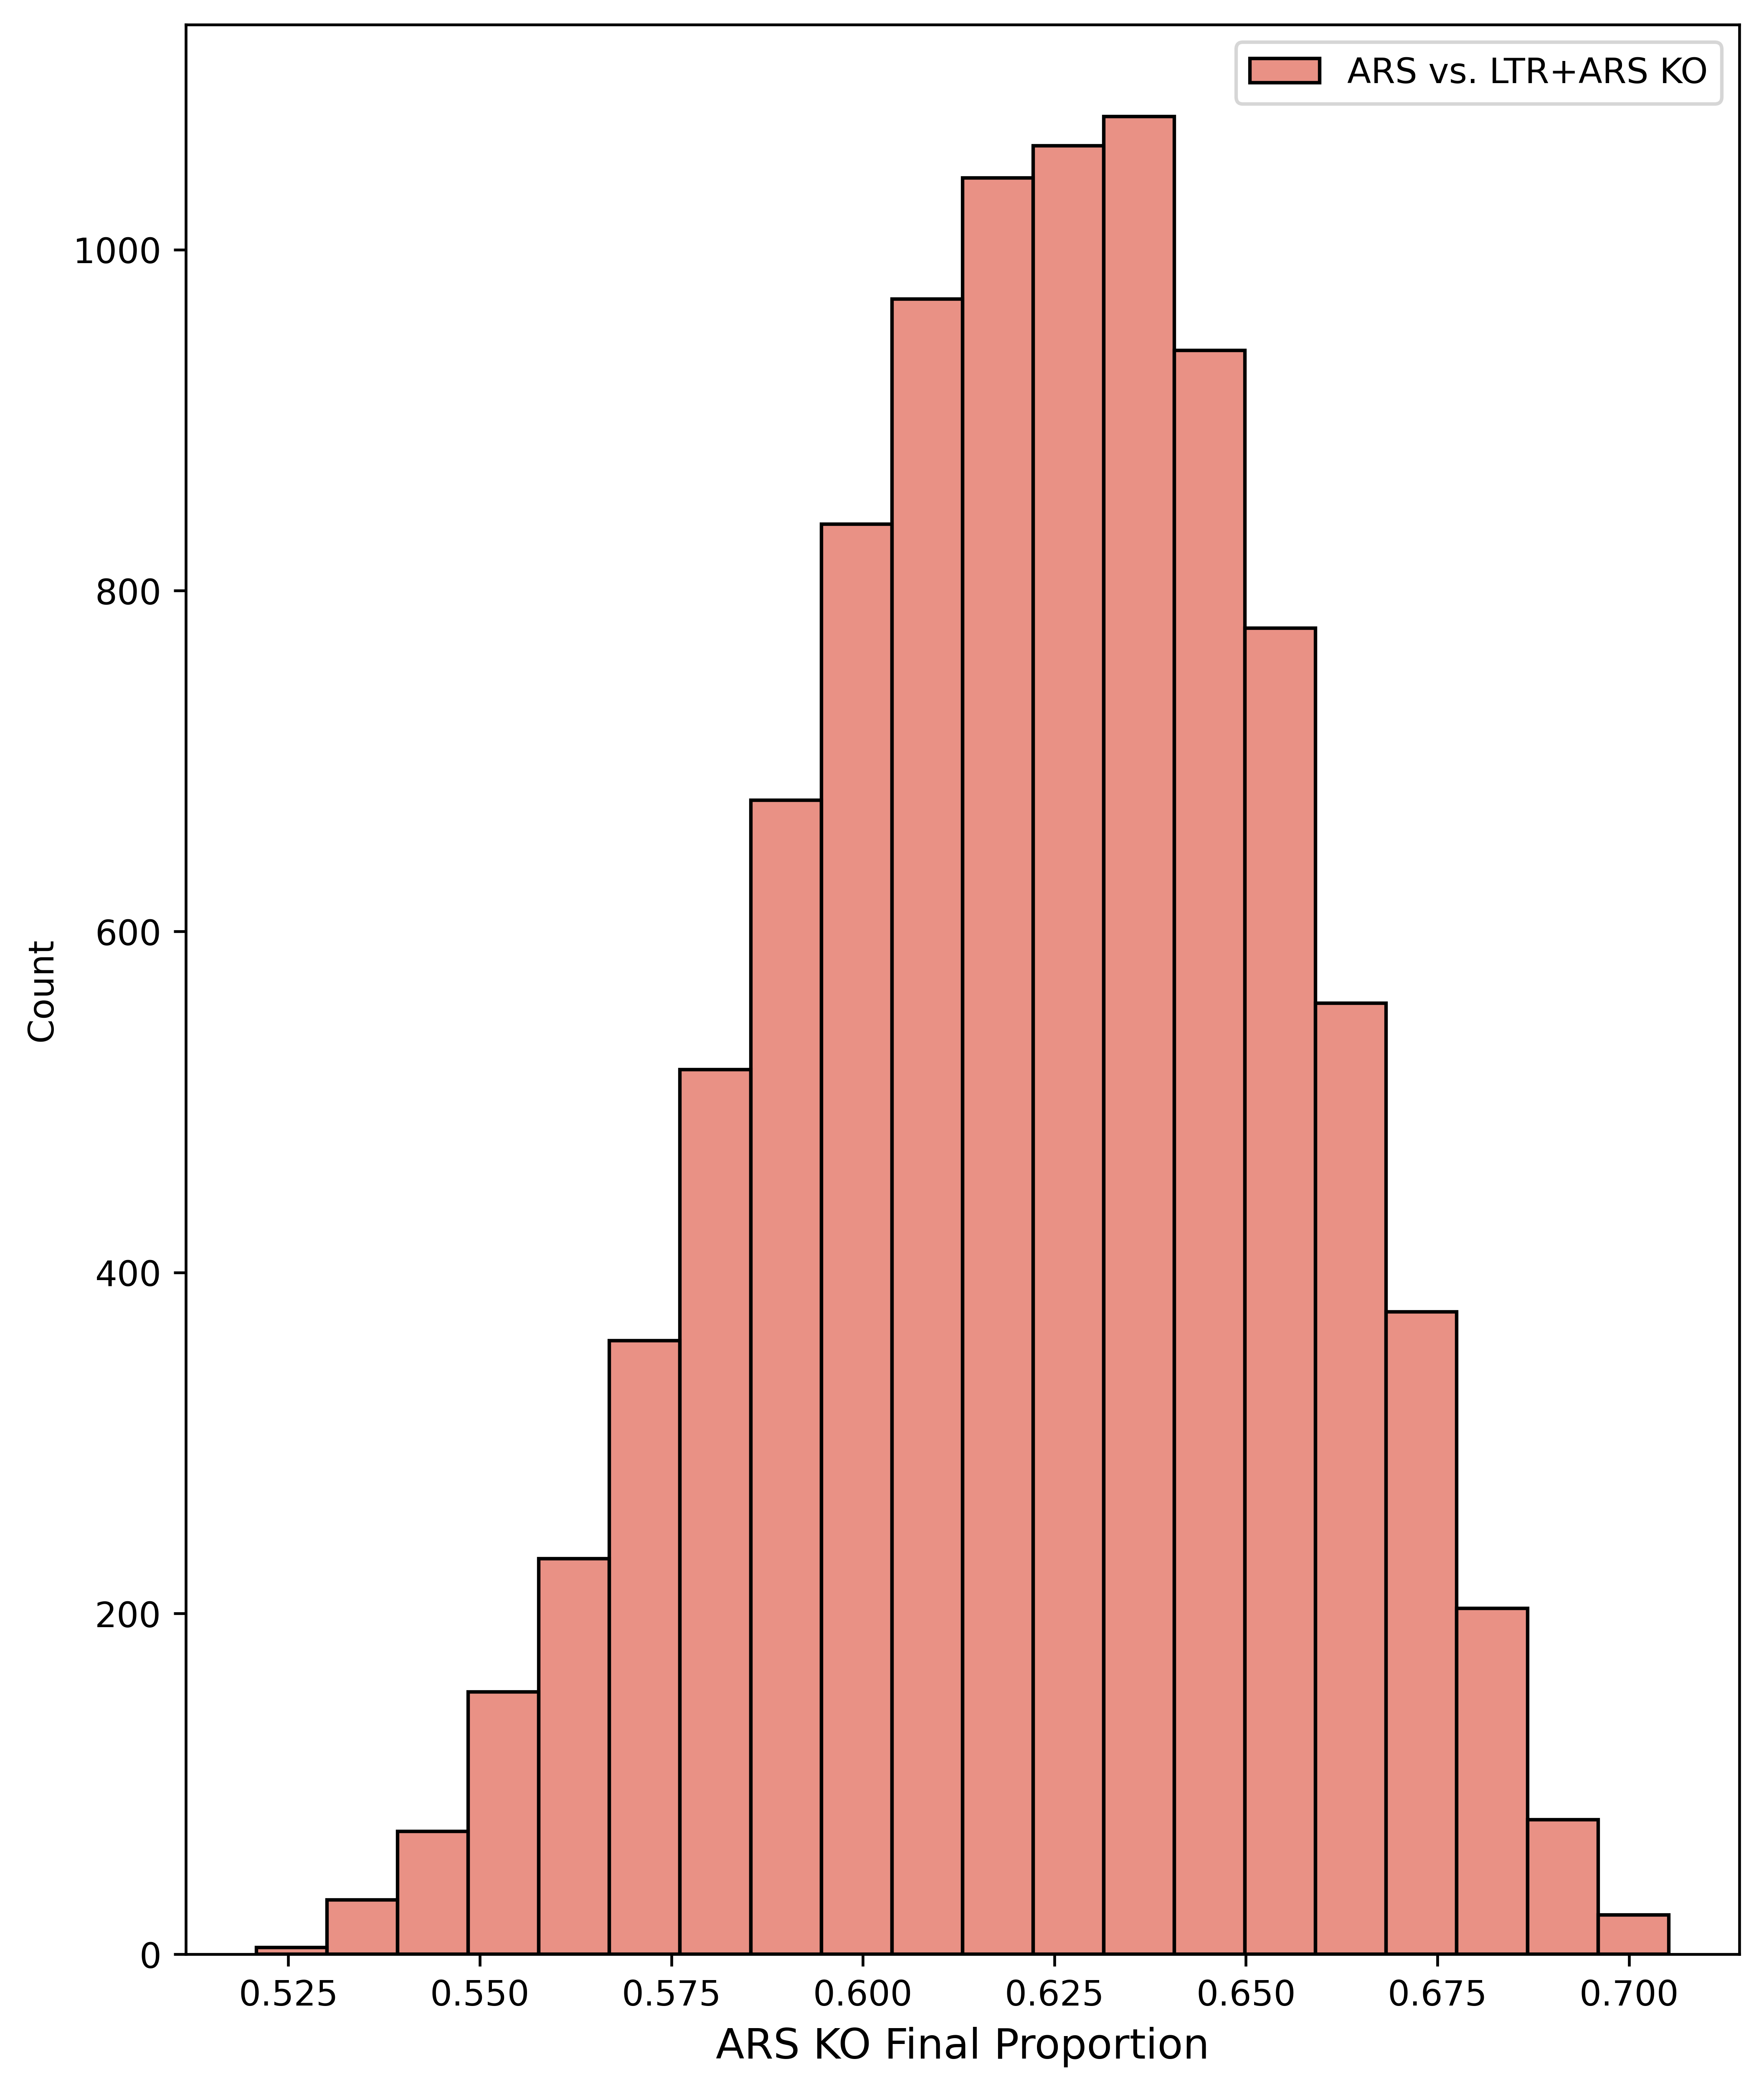

In [8]:
# ARS vs LTR+ARS
fig, ax = plt.subplots(figsize=(8,10))
ars_final_prop = competition_estimation('ars', 'all')
hst(ars_final_prop, color=rep_colors['ars'], label='ARS vs. LTR+ARS KO', bins=20, ax=ax)
ax.set_xlabel('ARS KO Final Proportion', fontsize=12)
ax.legend()